In [1]:
from osgeo import gdal, gdalconst
from osgeo.gdalconst import *
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
img_path = './FinalQ4Image.jpg'

In [3]:
ds = gdal.Open(img_path, GA_ReadOnly)

In [4]:
n_band = ds.RasterCount

In [5]:
img_width = 2448
img_height = 2448

In [6]:
img = np.zeros((img_width,img_height,n_band))
for i in range(n_band):
    band = ds.GetRasterBand(i+1)
    data = band.ReadAsArray()
    img[:,:,i] = data
data = None
band = None

In [7]:
img.shape

(2448, 2448, 3)

In [8]:
pointWater = pd.read_csv('./water_samples.csv').values
pointUrban = pd.read_csv('./urban_samples.csv').values
pointAgri = pd.read_csv('./agriculture_samples.csv').values
pointRange = pd.read_csv('./Range_samples.csv').values
pointBarren = pd.read_csv('./barren_samples.csv').values

In [9]:
def imgPointToData(img,point):
    dataOut = []
    for i in range(len(point)):
        dataOut.append(img[point[i,0],point[i,1]])
    return np.array(dataOut)

In [10]:
dataWater = imgPointToData(img,pointWater)
dataUrban = imgPointToData(img,pointUrban)
dataAgri = imgPointToData(img,pointAgri)
dataRange = imgPointToData(img,pointRange)
dataBarren = imgPointToData(img,pointBarren)

In [285]:
X_train = np.concatenate((dataWater[:8000],dataUrban[:8000],dataAgri[:8000],dataRange[:8000],dataBarren[:8000]))
y_train = np.ones((len(X_train)))
y_train[:8000] *= 0
y_train[8000:16000] *= 1
y_train[16000:24000] *= 2
y_train[24000:36000] *= 3
y_train[36000:40000] *= 4

X_test = np.concatenate((dataWater[8000:],dataUrban[8000:],dataAgri[8000:],dataRange[8000:],dataBarren[8000:]))
y_test = np.ones((len(X_test)))
y_test[:2000] *= 0
y_test[2000:4000] *= 1
y_test[4000:6000] *= 2
y_test[6000:8000] *= 3
y_test[8000:10000] *= 4

In [286]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(24000, 3)
(24000,)
(6000, 3)
(6000,)


In [287]:
idx1 = np.random.permutation(len(X_train))
X_train = X_train[idx1]
y_train = y_train[idx1]

idx2 = np.random.permutation(len(X_test))
X_test = X_test[idx2]
y_test = y_test[idx2]

X_train = X_train/255
X_test = X_test/255

In [288]:
y_train[2002:]

array([0., 2., 0., ..., 0., 0., 0.])

In [289]:
import sklearn
import xgboost as xgb

In [290]:
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold

In [291]:
kf = KFold(n_splits=3)

In [292]:
kf

KFold(n_splits=3, random_state=None, shuffle=False)

In [293]:
xgbc = xgb.XGBClassifier(max_depth=21,n_estimators=500,learning_rate=0.02)
xgbc.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.02, max_delta_step=0, max_depth=21,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [294]:
print(classification_report(y_test,xgbc.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.68      0.58      0.63      2000
         1.0       0.56      0.56      0.56      2000
         2.0       0.56      0.64      0.60      2000

    accuracy                           0.59      6000
   macro avg       0.60      0.59      0.59      6000
weighted avg       0.60      0.59      0.59      6000



In [295]:
import lightgbm as lgbm

In [296]:
lgbc = lgbm.LGBMClassifier(learning_rate=0.01,n_estimators=2000)
lgbc.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=2000, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [297]:
print(classification_report(y_test,lgbc.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.75      0.57      0.65      2000
         1.0       0.58      0.65      0.61      2000
         2.0       0.59      0.66      0.62      2000

    accuracy                           0.63      6000
   macro avg       0.64      0.63      0.63      6000
weighted avg       0.64      0.63      0.63      6000



In [298]:
(0.9*2000+0.62*8000)/10000

0.676

In [299]:
from sklearn.naive_bayes import GaussianNB

In [300]:
gc = GaussianNB()
gc.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [301]:
print(classification_report(y_test,gc.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.71      0.43      0.54      2000
         1.0       0.56      0.43      0.49      2000
         2.0       0.46      0.74      0.57      2000

    accuracy                           0.54      6000
   macro avg       0.58      0.54      0.53      6000
weighted avg       0.58      0.54      0.53      6000



In [302]:
from sklearn.ensemble import RandomForestClassifier

In [303]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [304]:
print(classification_report(y_test,rfc.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.67      0.59      0.63      2000
         1.0       0.56      0.56      0.56      2000
         2.0       0.57      0.64      0.60      2000

    accuracy                           0.60      6000
   macro avg       0.60      0.60      0.60      6000
weighted avg       0.60      0.60      0.60      6000



In [305]:
from sklearn.svm import SVC

In [306]:
svmc = SVC(C=3,degree=5)
svmc.fit(X_train,y_train)

/Users/layyer/anaconda3/envs/remote/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=3, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=5, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [307]:
print(classification_report(y_test,svmc.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.76      0.41      0.53      2000
         1.0       0.61      0.47      0.53      2000
         2.0       0.47      0.80      0.60      2000

    accuracy                           0.56      6000
   macro avg       0.61      0.56      0.55      6000
weighted avg       0.61      0.56      0.55      6000



In [162]:
from sklearn.ensemble import VotingClassifier

In [165]:
esvc = VotingClassifier(estimators=[('xgb',xgbc),('lgb',lgbc),('rf',rfc)],voting='soft')
esvc.fit(X_train,y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=21, min_child_weight=1,
                                            missing=None, n_estimators=300,
                                            n_jobs=1, nthread=None,
                                            objective='multi:softprob',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight...
                                                     class_weight=None,
                                                     criterion='gini',
              

In [166]:
print(classification_report(y_test,esvc.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      2000
         1.0       0.64      0.51      0.57      2000
         2.0       0.52      0.48      0.50      2000
         3.0       0.39      0.71      0.51      2000
         4.0       0.79      0.33      0.47      2000

    accuracy                           0.60     10000
   macro avg       0.65      0.60      0.60     10000
weighted avg       0.65      0.60      0.60     10000



In [72]:
from tensorflow import keras

In [311]:
y_train_encode = keras.utils.to_categorical(y_train)
y_test_encode = keras.utils.to_categorical(y_test)

In [316]:
def nnmodel(input_shape):
    X_input = keras.layers.Input((input_shape))
    X = keras.layers.Dense(1024,activation='relu')(X_input)
    X = keras.layers.Dense(128,activation='relu')(X)
    X = keras.layers.Dense(3,activation='softmax')(X)
    model = keras.models.Model(inputs=X_input, outputs=X, name='model')
    return model

In [317]:
mymodel = nnmodel(X_train[0].shape)
mymodel.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
mymodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 3)                 0         
_________________________________________________________________
dense_43 (Dense)             (None, 1024)              4096      
_________________________________________________________________
dense_44 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_45 (Dense)             (None, 3)                 387       
Total params: 135,683
Trainable params: 135,683
Non-trainable params: 0
_________________________________________________________________


In [318]:
mymodel.fit(X_train,y_train_encode,batch_size=32,epochs=20,validation_data=(X_test,y_test_encode))

Train on 24000 samples, validate on 6000 samples
Epoch 1/20
24000/24000 [==============================] - 6s 240us/sample - loss: 0.9585 - acc: 0.5282 - val_loss: 0.9508 - val_acc: 0.5492
Epoch 2/20
24000/24000 [==============================] - 5s 221us/sample - loss: 0.9256 - acc: 0.5601 - val_loss: 0.9189 - val_acc: 0.5623
Epoch 3/20
24000/24000 [==============================] - 5s 218us/sample - loss: 0.9096 - acc: 0.5702 - val_loss: 0.9052 - val_acc: 0.5728
Epoch 4/20
24000/24000 [==============================] - 5s 222us/sample - loss: 0.9013 - acc: 0.5789 - val_loss: 0.9011 - val_acc: 0.5717
Epoch 5/20
24000/24000 [==============================] - 6s 231us/sample - loss: 0.8933 - acc: 0.5838 - val_loss: 0.8870 - val_acc: 0.5813
Epoch 6/20
24000/24000 [==============================] - 5s 222us/sample - loss: 0.8908 - acc: 0.5897 - val_loss: 0.8906 - val_acc: 0.5782
Epoch 7/20
24000/24000 [==============================] - 7s 272us/sample - loss: 0.8890 - acc: 0.5871 - val_lo

KeyboardInterrupt: 

In [315]:
his = mymodel.history.history
plt.plot(his['acc'])
plt.plot(his['val_acc'])

AttributeError: 'Model' object has no attribute 'history'

In [199]:
X_train[0]

array([0.61176471, 0.48235294, 0.34509804])

In [200]:
pred = np.argmax(mymodel.predict(X_test),axis=1)

In [236]:
from scipy.signal import medfilt

In [220]:
p2 = medfilt(pred,kernel_size=3)

In [221]:
print(classification_report(y_test,p2))

              precision    recall  f1-score   support

         0.0       0.69      0.37      0.48      2000
         1.0       0.32      0.31      0.32      2000
         2.0       0.30      0.46      0.36      2000
         3.0       0.27      0.53      0.35      2000
         4.0       0.52      0.01      0.03      2000

    accuracy                           0.33     10000
   macro avg       0.42      0.33      0.31     10000
weighted avg       0.42      0.33      0.31     10000



In [168]:
mymodel.evaluate(X_test,y_test_encode)

10000/10000 [==============================] - 0s 50us/sample - loss: 0.8780 - acc: 0.6164


[0.8780351026535034, 0.6164]

In [169]:
pred.shape

(10000,)

In [224]:
img = img.reshape(((2448* 2448, 3)))
img = img/255

In [225]:
predimg = mymodel.predict(img)

In [255]:
predimg_dec = np.argmax(predimg,axis=1)
#predimg_dec =medfilt(predimg_dec,kernel_size=3)
#predimg_dec = predimg

In [256]:
colormap = np.zeros_like(img).astype(int)

In [257]:
for i in range(len(colormap)):
    if(predimg_dec[i] == 0):
        #water
        colormap[i] = [0,0,255]
    elif(predimg_dec[i]==1):
        #urban
        colormap[i] = [0,255,255]
    elif (predimg_dec[i] ==2):
        #argi
        colormap[i] = [255,255,0]
    elif (predimg_dec[i] == 3):
        #range
        colormap[i] = [255,0,255]
    elif (predimg_dec[i] == 4):
        #barren
        colormap[i] = [255,255,255]

In [258]:
predimg[0]

array([2.1382679e-05, 1.2163552e-01, 3.1559619e-01, 4.2307845e-01,
       1.3966849e-01], dtype=float32)

In [259]:
colormap = colormap.reshape((2448,2448,3))

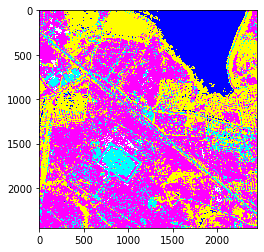

In [260]:
plt.imshow(colormap)

([array([5158946.,   85798.,   60119.,   30307.,   30502.,   17502.,
           15675.,   13051.,   12778.,  568026.]),
  array([1203077., 2739956., 1013633.,  396885.,  194907.,  139780.,
           93787.,   66633.,   41589.,  102457.]),
  array([1221419., 1117671., 1396672.,  856394.,  452014.,  373052.,
          228038.,  168081.,  132367.,   46996.]),
  array([1279255.,  581028.,  644786., 1033556., 1112818.,  721364.,
          568673.,   51224.,       0.,       0.]),
  array([4.589292e+06, 7.475250e+05, 2.749180e+05, 2.328310e+05,
         1.406310e+05, 7.412000e+03, 8.800000e+01, 7.000000e+00,
         0.000000e+00, 0.000000e+00])],
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 5 Lists of Patches objects>)

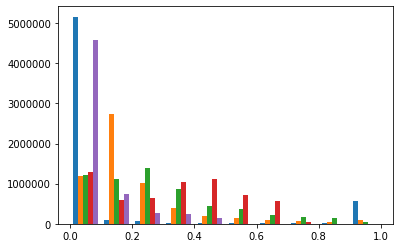

In [235]:
plt.hist(predimg)

In [232]:
from sklearn.metrics import confusion_matrix,cohen_kappa_score

In [235]:
confmat = confusion_matrix(y_test,pred)
confmat

array([[1881,    0,  108,   11,    0],
       [  11,  834,  339,  744,   72],
       [  26,   52,  947,  968,    7],
       [  11,   81,  229, 1669,   10],
       [   0,  113,   88,  966,  833]])

In [249]:
user_acc = [confmat[0,0],confmat[1,1],confmat[2,2],confmat[3,3],confmat[4,4]]/np.sum(confmat,axis=1)*100
user_acc

array([94.05, 41.7 , 47.35, 83.45, 41.65])

In [252]:
prod_acc = [confmat[0,0],confmat[1,1],confmat[2,2],confmat[3,3],confmat[4,4]]/np.sum(confmat,axis=0)*100
prod_acc

array([97.51166407, 77.22222222, 55.34774985, 38.29738412, 90.34707158])

In [261]:
overall_acc = np.sum([confmat[0,0],confmat[1,1],confmat[2,2],confmat[3,3],confmat[4,4]])/10000
overall_acc

0.6164

In [263]:
(overall_acc-1/5)/(1-1/5)

0.5204999999999999

In [233]:
cohen_kappa_score(y_test,pred)

0.5205

In [254]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96      2000
         1.0       0.77      0.42      0.54      2000
         2.0       0.55      0.47      0.51      2000
         3.0       0.38      0.83      0.53      2000
         4.0       0.90      0.42      0.57      2000

    accuracy                           0.62     10000
   macro avg       0.72      0.62      0.62     10000
weighted avg       0.72      0.62      0.62     10000



In [243]:
confmat[0]

array([1881,    0,  108,   11,    0])

In [251]:
np.sum(confmat,axis=0)

array([1929, 1080, 1711, 4358,  922])